In [1]:
import pandas as pd 
from scipy.stats import hypergeom
import numpy as np
import seaborn as sns 
import time
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
from sklearn.manifold import TSNE
from scipy.spatial import distance
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
from adjustText import adjust_text
import scipy.stats

In [2]:
def hypergeometric_test(x, M, n, N):
    """
    The hypergeometric distribution models drawing objects from a bin.
    - M is total number of objects
    - n is total number of Type I objects. 
    - x (random variate) represents the number of Type I objects in N drawn without replacement from the total population
    """
    assert n <= M
    assert x <= n
    assert N <= M
    pv_le = hypergeom.cdf(x+1, M, n, N)
    pv_gt = hypergeom.sf(x-1, M, n, N)# 1-cdf sometimes more accurate
    return pv_le, pv_gt 

def pearson_distance(x1, x2):
    return 1 - scipy.stats.pearsonr(x1, x2)[0]



## Increasing k will make the distances further away from the corresponding points 
def repel_labels(ax, x, y, labels, k=0.01, arrow_colors="gray"):
    G = nx.DiGraph()
    data_nodes = []
    init_pos = {}
    for xi, yi, label in zip(x, y, labels):
        data_str = 'data_{0}'.format(label)
        G.add_node(data_str)
        G.add_node(label)
        G.add_edge(label, data_str)
        data_nodes.append(data_str)
        init_pos[data_str] = (xi, yi)
        init_pos[label] = (xi, yi)

    pos = nx.spring_layout(G, pos=init_pos, fixed=data_nodes, k=k)

    # undo spring_layout's rescaling
    pos_after = np.vstack([pos[d] for d in data_nodes])
    pos_before = np.vstack([init_pos[d] for d in data_nodes])
    scale, shift_x = np.polyfit(pos_after[:,0], pos_before[:,0], 1)
    scale, shift_y = np.polyfit(pos_after[:,1], pos_before[:,1], 1)
    shift = np.array([shift_x, shift_y])
    for key, val in pos.items():
        pos[key] = (val*scale) + shift

    for i, (label, data_str) in enumerate(G.edges()):
        if type(arrow_colors) == list:
            color = arrow_colors[i]
        else:
            color = arrow_colors
        ax.annotate(label,
                    xy=pos[data_str], 
                    xycoords='data',
                    xytext=pos[label], 
                    textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                                    shrinkA=0, shrinkB=0,
                                    connectionstyle="arc3", 
                                    color=color) 
                   )
    # expand limits
    all_pos = np.vstack(pos.values())
    x_span, y_span = np.ptp(all_pos, axis=0)
    mins = np.min(all_pos-x_span*0.15, 0)
    maxs = np.max(all_pos+y_span*0.15, 0)
    ax.set_xlim([mins[0], maxs[0]])
    ax.set_ylim([mins[1], maxs[1]])

In [26]:
screen_df = pd.read_excel("./data/0621_ldl_GWAS_mageck_summary.xlsx", sheet_name = 2)
contained_genes = set(screen_df["id"].values)
decrease_genes = set(pd.read_excel("./data/0621_ldl_GWAS_mageck_summary.xlsx", sheet_name = 3)["id"].values)
increase_genes = set(pd.read_excel("./data/0621_ldl_GWAS_mageck_summary.xlsx", sheet_name = 4)["id"].values)

In [27]:
achilles = pd.read_csv("/Users/jdf36/Desktop/bwh/LDL_screen/Achilles_proximity_corrected.csv", index_col = 0)
unreliable_columns = []

# a few columns have exactly 707 nan values, removing these columns allows 
# us to keep more genes instead of dropping all rows with nan using df.dropna()
# the few columns account for most of the nan vals 

for c in achilles.columns:
    nan_vals = achilles[c].isna().sum()
    if nan_vals >= 707:
        unreliable_columns.append(c)
achilles = achilles.drop(columns = unreliable_columns)
achilles = achilles.dropna()
tsne = TSNE(n_components = 2, learning_rate = 50, verbose = 1, random_state = 42)
tsne_results = tsne.fit_transform(achilles)
achilles['tsne-2d-one'] = tsne_results[:,0]
achilles['tsne-2d-two'] = tsne_results[:,1]

achilles_gen

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18117 samples in 0.008s...
[t-SNE] Computed neighbors for 18117 samples in 13.831s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18117
[t-SNE] Computed conditional probabilities for sample 2000 / 18117
[t-SNE] Computed conditional probabilities for sample 3000 / 18117
[t-SNE] Computed conditional probabilities for sample 4000 / 18117
[t-SNE] Computed conditional probabilities for sample 5000 / 18117
[t-SNE] Computed conditional probabilities for sample 6000 / 18117
[t-SNE] Computed conditional probabilities for sample 7000 / 18117
[t-SNE] Computed conditional probabilities for sample 8000 / 18117
[t-SNE] Computed conditional probabilities for sample 9000 / 18117
[t-SNE] Computed conditional probabilities for sample 10000 / 18117
[t-SNE] Computed conditional probabilities for sample 11000 / 18117
[t-SNE] Computed conditional probabilities for sample 12000 / 18117
[t-SNE] Computed conditional probabilities for sa

In [38]:
screen_df = pd.read_excel("./data/0621_ldl_GWAS_mageck_summary.xlsx", sheet_name = 2)
contained_genes = achilles_genes.intersection(set(screen_df["id"].values))
decrease_genes = set(pd.read_excel("./data/0621_ldl_GWAS_mageck_summary.xlsx", sheet_name = 3)["id"].values)
increase_genes = set(pd.read_excel("./data/0621_ldl_GWAS_mageck_summary.xlsx", sheet_name = 4)["id"].values)


module_size = 0.2
module_df = pd.read_csv(f"./data/coessentiality/GO_Annotated_Modules_d_{module_size}.csv", index_col = "Cluster")
overlaps = []


all_genes = set()
for index, row in module_df.iterrows():
    members = set(row["Members"].split(" "))
    all_genes = all_genes.union(members)
    overlap = len(members.intersection(contained_genes))
    overlaps.append(overlap)
    
module_df["overlap_490_screen"] = overlaps

hypergeom_p_vals = []
M = len(all_genes)
n = len(contained_genes)

for index, row in module_df.iterrows():
    members = set(row["Members"].split(" "))
    _, pv_gt = hypergeometric_test(row["overlap_490_screen"], M, n, len(members))
    hypergeom_p_vals.append(pv_gt)

module_df["hypergeom_p"] = hypergeom_p_vals
module_df = module_df.sort_values(by = "hypergeom_p")
n_tests = len(module_df)
alpha = 0.1
is_signif = []
for counter, (index, row) in enumerate(module_df.iterrows()):
    p = row["hypergeom_p"]
    if p <= ((counter+1)/ n_tests) * alpha:
        is_signif.append(True)
    else:
        is_signif.append(False)
        

module_df[f"FDR_significant_{alpha}"] = is_signif 

module_df.to_csv("signif_annotated_d_0_2.csv")

In [67]:
fn_to_file = {
    "sgDENND4C_500topOEgenes": "./data/sgDENND4C_500topOEgenes.xlsx",
    "sgHYOU1 upregulated genes": "./data/sgHYOU1 upregulated genes.xlsx",
    "sgCSK OE genes": "./data/sgCSK OE genes.xlsx",
}



module_size = 0.2
module_df = pd.read_csv(f"./data/coessentiality/GO_Annotated_Modules_d_{module_size}.csv", index_col = "Cluster")

for name, f in fn_to_file.items():
    list_df = pd.read_excel(f)
    contained_genes = achilles_genes.intersection(set(list_df[list_df.columns[0]].values))

    overlaps = []
    all_genes = set()
    for index, row in module_df.iterrows():
        members = set(row["Members"].split(" "))
        all_genes = all_genes.union(members)
        overlap = len(members.intersection(contained_genes))
        overlaps.append(overlap)
       
    module_df["n overlap " + name] = overlaps
    
    hypergeom_p_vals = []
    M = len(all_genes)
    n = len(contained_genes)

    for index, row in module_df.iterrows():
        members = set(row["Members"].split(" "))
        _, pv_gt = hypergeometric_test(row["n overlap " + name], M, n, len(members))
        hypergeom_p_vals.append(pv_gt)

    module_df[name + "_hypergeom_p"] = hypergeom_p_vals
    module_df = module_df.sort_values(by = name + "_hypergeom_p")
    n_tests = len(module_df)
    alpha = 0.1
    is_signif = []
    for counter, (index, row) in enumerate(module_df.iterrows()):
        p = row[name + "_hypergeom_p"]
        if p <= ((counter+1)/ n_tests) * alpha:
            is_signif.append(True)
            print(name, "found")
        else:
            is_signif.append(False)
            
    module_df[name + "is signif FDR 0.1"] = is_signif
    
module_df.to_csv("sg_gene_enriched_modules_0.2.csv")

sgHYOU1 upregulated genes found
sgHYOU1 upregulated genes found
sgHYOU1 upregulated genes found
sgHYOU1 upregulated genes found
sgHYOU1 upregulated genes found
sgHYOU1 upregulated genes found
sgHYOU1 upregulated genes found
sgHYOU1 upregulated genes found
sgHYOU1 upregulated genes found


In [64]:
print(np.min(module_df['sgCSK OE genes_hypergeom_p'].values))
print(np.min(module_df['sgHYOU1 upregulated genes_hypergeom_p'].values))
print(np.min(module_df['sgDENND4C_500topOEgenes_hypergeom_p'].values))

0.0018690154566681316
7.956275654439735e-05
0.008220056451974506


In [54]:
module_df.columns

Index(['Size', 'Density', 'Internal weight', 'External weight', 'Quality',
       'P-value', 'Members', 'Top GO Terms', 'Top GO Term p-values',
       'Top GO FDRs', 'Top GO Term Fold Enrichments',
       'n overlap sgCSK OE genes', 'sgCSK OE genes_hypergeom_p',
       'sgCSK OE genesis signif FDR 0.1', 'n overlap sgDENND4C_500topOEgenes',
       'sgDENND4C_500topOEgenes_hypergeom_p',
       'sgDENND4C_500topOEgenesis signif FDR 0.1',
       'n overlap sgHYOU1 upregulated genes',
       'sgHYOU1 upregulated genes_hypergeom_p',
       'sgHYOU1 upregulated genesis signif FDR 0.1'],
      dtype='object')

/Users/jdf36/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


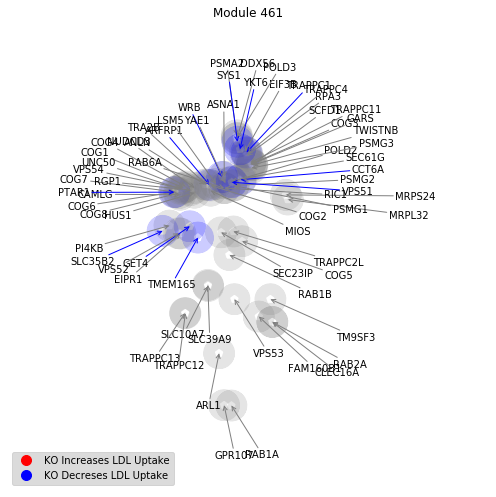

In [23]:
cluster = 461
# cluster = 416
# cluster = 255



gene_list = module_df.loc[cluster]["Members"].split(" ")
dist_cutoff = 0.

v_from = []
v_to = []

above_cutoff = 0
below_cutoff = 0

G = nx.Graph()
G.add_nodes_from(gene_list)

for g1 in gene_list:
    for g2 in gene_list:
        v1 = achilles.loc[g1]
        v2 = achilles.loc[g2]
        distance = pearson_distance(v1.values, v2.values)
        if distance < dist_cutoff:
            G.add_edge(g1, g2, weight = distance)
                        
pos = {}

for g in gene_list:
    position_row = achilles.loc[g]
    pos[g] = (position_row["tsne-2d-one"], position_row["tsne-2d-two"])
   
colors = []
for g in gene_list:
    if g in decrease_genes:
        colors.append("blue")
    elif g in increase_genes:
        colors.append("red")
    else:
        colors.append("gray")

fig, ax = plt.subplots(figsize = (7,7))
nx.draw(
    G, 
    pos, 
    with_labels=False, 
    ax=ax, 
    node_size=4, 
    node_color=colors, 
    node_shape="*", 
    edge_color="black", 
    alpha=0.2, 
    linewidths=30
)
fig.tight_layout()

k = 4
selected_items = achilles.loc[gene_list]
repel_labels(ax, selected_items["tsne-2d-one"], selected_items["tsne-2d-two"], list(gene_list), k = k, arrow_colors=colors)      
ax.set_xlabel("tSNE 1")
ax.set_ylabel("tSNE 2")

patches = [
    plt.plot([],[], marker="o", ms=10, ls="", mec=None, color="Red", label="KO Increases LDL Uptake")[0],
    plt.plot([],[], marker="o", ms=10, ls="", mec=None, color="Blue", label="KO Decreses LDL Uptake")[0]
]

ax.legend(handles=patches, bbox_to_anchor=(0.0,0.0), loc='lower left', ncol=1, facecolor="lightgray", numpoints=1 )
fig.suptitle("Module " + str(cluster))

fig.tight_layout()

In [16]:
module_size = 0.2
module_df = pd.read_csv(f"./data/coessentiality/GO_Annotated_Modules_d_{module_size}.csv", index_col = "Cluster")
overlaps = []
best_pval_go = []
best_go_term = []

for index, row in module_df.iterrows():
    terms = row["Top GO Terms"].split("|")
    p_vals = list(map(lambda x : float(x), row["Top GO Term p-values"].split("|")))
    terms_df = pd.DataFrame.from_dict({"term" : terms, "p_val_go" : p_vals})
    min_val = terms_df.sort_values(by = "p_val_go").iloc[0]
    min_p, min_go = min_val["p_val_go"], min_val["term"]
    best_pval_go.append(min_p)
    best_go_term.append(min_go)
 

module_df["best_p"] = best_pval_go
module_df["best_term"] = best_go_term
module_df = module_df.sort_values(by = "best_p")

m = len(module_df)
alpha = 0.1
signif = []
for counter, (index, row) in enumerate(module_df.iterrows()):
    p = row["best_p"]
    if p <= ((counter + 1) / m) * alpha:
        signif.append(True)
    else:
        signif.append(False)
        
module_df["signif_go_fdr_0.1"] =  signif

In [39]:
module_size = 0.2
module_df = pd.read_csv(f"./data/coessentiality/GO_Annotated_Modules_d_{module_size}.csv", index_col = "Cluster")
less_than_fdr = []
m = len(module_df)
for index, row in module_df.iterrows():
    terms = row["Top GO Terms"].split("|")
    p_vals = list(map(lambda x : float(x), row["Top GO Term p-values"].split("|")))
    fdrs = list(map(lambda x : float(x), row["Top GO FDRs"].split("|")))
    found = False
    for p, fdr in zip(p_vals, fdrs):
        if float(p) <= (fdr / float(m)):
            found = True
   
    less_than_fdr.append(found)
module_df["less_than_Go_FDR"] = less_than_fdr  

len(module_df.loc[module_df["less_than_Go_FDR"]]) / len(module_df)

0.8502604166666666

In [20]:
module_df.columns 

Index(['Size', 'Density', 'Internal weight', 'External weight', 'Quality',
       'P-value', 'Members', 'Top GO Terms', 'Top GO Term p-values',
       'Top GO FDRs', 'Top GO Term Fold Enrichments', 'best_p', 'best_term',
       'signif_go_fdr_0.1'],
      dtype='object')